In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft, optimize

In [2]:
from ImgProcessing import *     # import all functions from ../Codes/ImgProcessing.py
from KSVD import *              # import all functions from ../Codes/KSVD.py

Read the images

(256, 256)


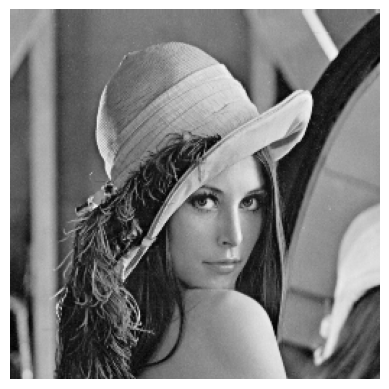

In [3]:
# read the grey scale image
img_lena = plt.imread('../Pictures/lena.tif')
print(img_lena.shape)
Showing(img_lena)

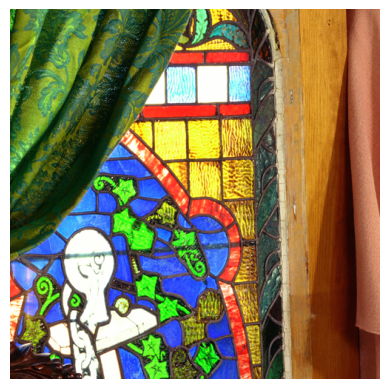

In [4]:
# import the RGB image
img_01 = plt.imread('../Pictures/McM/McM01.tif')

'''
img_01.shape = (500, 500, 3)
where 3 means 3 channels: R, G, B
Extract three channels respectively
'''
img_01_R = img_01[:, :, 0]
img_01_G = img_01[:, :, 1]
img_01_B = img_01[:, :, 2]

Showing(img_01_R, img_01_G, img_01_B)

# Step 1. Cut the image into patches

(256, 441)


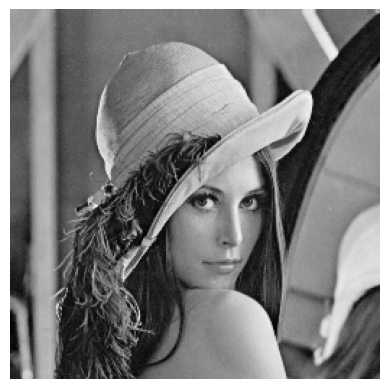

In [5]:
P = 2**8
overlapping_rate = 0.25

patches, DC_component = Img2patch(img_lena, P, overlapping_rate)
print(patches.shape)

imgg = Img2patch(patches, 0.25, DC_component, inv=True)
Showing(imgg)

# Step 2: Create the initial dictionary

initial dictionary: DCT over-complete dictionary

In [6]:
mDCT = fft.dct(np.eye(P*2), norm='ortho')[:P]

# Step 3: K-SVD

K-SVD算法是一种用于字典学习的迭代优化算法，其步骤如下：

1. **初始化字典**：开始时需要一个初始的字典。可以是随机选择的字典或通过其他方式预先构建的字典。

2. **稀疏编码**：对于给定的样本集合，使用当前的字典对样本进行稀疏编码。这意味着用字典中的原子线性组合来表示每个样本，通常使用一些稀疏编码方法，比如OMP（Orthogonal Matching Pursuit）或基于凸优化的方法。

3. **更新字典**：在这一步中，逐个更新字典中的原子（基向量）。对于每个原子，以下步骤在所有样本上进行：
   - **选取样本**：选取使用当前原子表示的样本。
   - **更新原子**：对选定的样本进行残差计算，并使用某种优化方法（如最小化残差的方式）来更新字典中的原子。

4. **重复迭代**：重复步骤2和步骤3，直到满足停止条件，比如达到最大迭代次数、字典不再发生显著变化、或者达到一定的收敛条件。

在K-SVD算法中，关键的步骤是稀疏编码和字典更新。稀疏编码确定了如何用当前的字典表示样本，而字典更新阶段则利用这些表示来更新字典，使其能够更好地拟合样本数据，提高稀疏表示的质量。

K-SVD算法通常应用于信号处理、图像处理等领域，用于从数据中学习最能代表数据特征的基本元素。



### OMP 稀疏编码

OMP（Orthogonal Matching Pursuit）是一种用于稀疏编码的算法，用于找到一组基向量的线性组合，最能够拟合给定观测信号的稀疏表示。其步骤如下：

- **初始化**：设输入信号为y，字典为D（包含一组基向量），稀疏表示向量为x（初始化为零向量）。
- **迭代**：
   1. 计算残差：$ r = y - Dx $。
   2. 选择最相关的原子：找到字典D中与残差r最相关（内积最大）的基向量，假设是第k个基向量。
   3. 更新稀疏表示：$x_k$（第k个系数）更新为$x_k = x_k + \langle d_k, r \rangle$，其中$d_k$是字典中的第k个基向量。
   4. 更新残差：$r = r - \langle d_k, r \rangle \cdot d_k$。
   5. 终止条件：检查稀疏表示向量x是否满足所需的稀疏度或残差大小要求，如果不满足，则继续迭代。

这个算法通过选择与当前残差最相关的基向量来逐步构建稀疏表示，直到达到所需的稀疏度或满足残差收敛要求。OMP是一种简单但有效的稀疏编码方法，在信号处理和压缩感知等领域得到广泛应用。

In [7]:
mD = mDCT * 2**0.5
mX = OMP(mD, patches, 4, eps=1)

### K-SVD

在K-SVD（K-Singular Value Decomposition）算法中，字典更新是算法的关键步骤之一，其目的是通过迭代过程不断优化字典中的原子（基向量）。字典更新过程通常分为以下几个步骤：

1. **选取字典中的原子**：
   - 对于每一个字典中的原子（基向量），依次进行更新。

2. **选取相关样本**：
   - 对于当前待更新的原子，找到使用该原子进行稀疏编码的样本。
   
3. **更新原子**：
   - 通过优化方法更新当前选定的原子，以减小对应样本的残差，常用的方式是最小化残差。
   - 更新原子时，可以采用单个原子的更新策略，基于优化方法更新该原子的系数以最小化残差。

4. **更新残差**：
   - 对于每个使用当前更新原子进行稀疏表示的样本，根据新的原子和系数计算残差。

5. **重复迭代**：
   - 对所有字典中的原子重复上述步骤，直到满足停止条件（如达到最大迭代次数或字典变化不大）。

具体步骤可能根据K-SVD的具体实现和优化策略而有所不同。但总的来说，K-SVD算法中的字典更新阶段是通过迭代地对字典中的原子进行优化，以提高对样本数据的拟合能力。这种优化通常涉及到最小化残差的过程，可以利用不同的数值优化方法来实现。

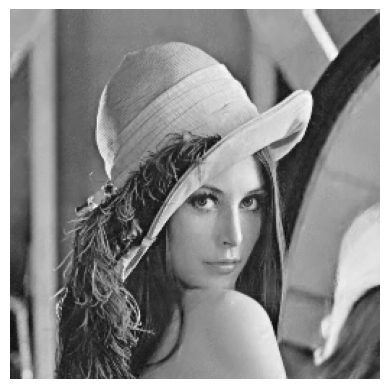

In [10]:
for _ in range(10):
    mD = DictLearn(mD, mX, patches)
    mX = OMP(mD, patches, 4, eps=1)

patches_new = mD @ mX
img_new = Img2patch(patches_new, overlapping_rate, DC_component, inv=True)
Showing(img_new)

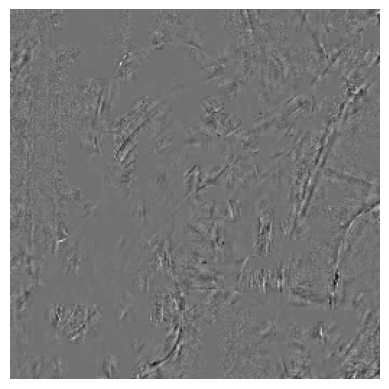

In [11]:
delta = img_lena - img_new
Showing(delta)